# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
funcs = os.listdir('functions')

for func in funcs:
    if func.startswith('__') or func == 'import_all_functions.py':
        continue
    func = func.replace('.py','')
    print(f'{func} imported')
    exec(f'from functions.{func} import *')

import_to_df imported
impute_cond_mean imported
get_kaggle_data imported
test imported
process_ticket imported
process_cabin imported
process_name imported
process_data imported


In [3]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as pyplot
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', None)

In [4]:
files = get_kaggle_data(competition="titanic")

files downloaded for titanic competition
   test.csv
   train.csv
   gender_submission.csv
located in /competition_data/


In [5]:
input_data = import_to_df(files)

In [6]:
train = input_data['train'].copy()
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [7]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

Missing values in Age column

In [8]:
display(len(train[train['Age'].isna()]))
display(len(train[train['Age'].isna()]) / len(train))

177

0.19865319865319866

Nearly 20% of ages missing. Lets impute those using the mean of Pclass as gender

In [9]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

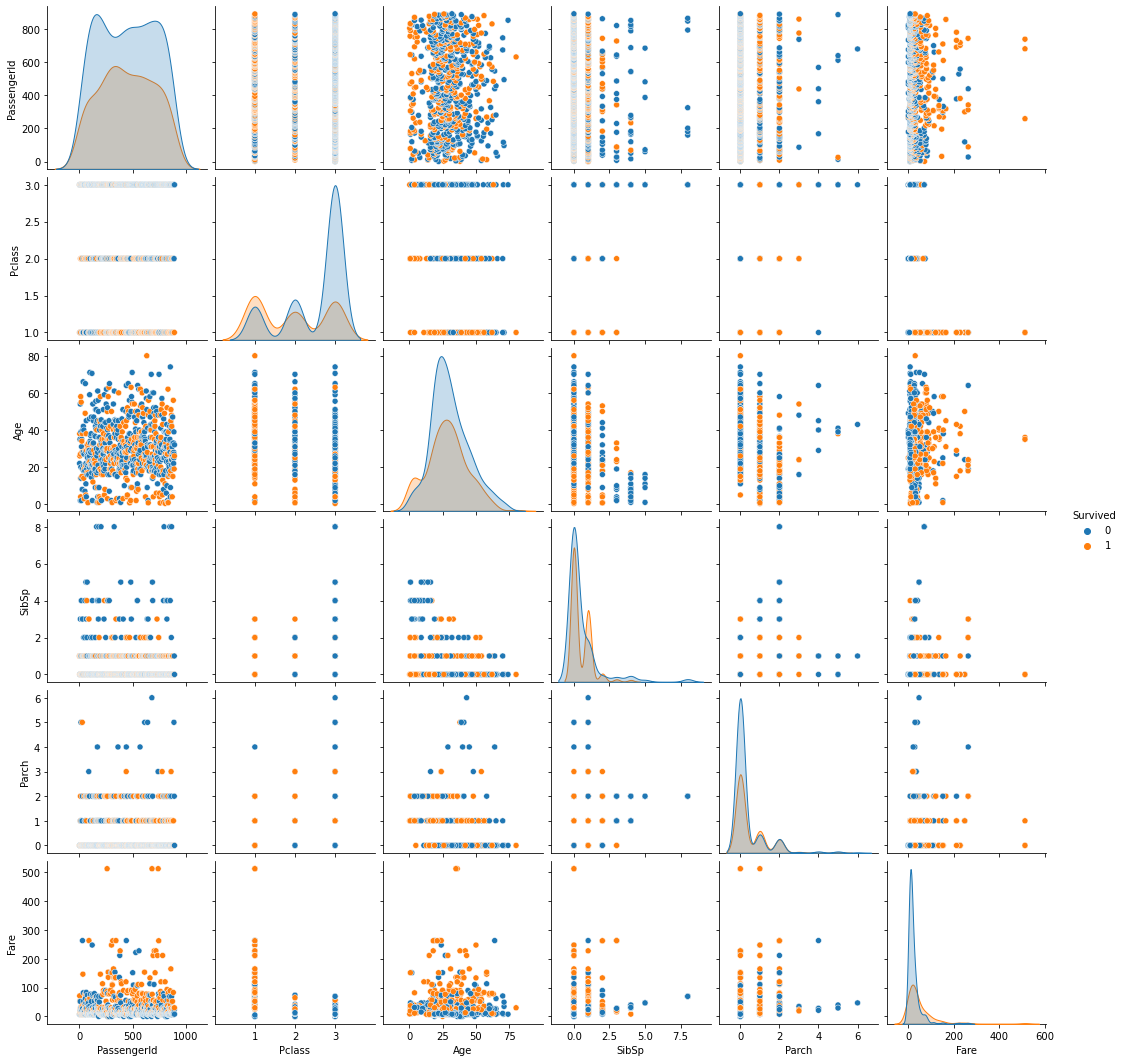

In [10]:
sns.pairplot(train, hue='Survived')

Pclass seems to be strong predictor of survival with class 3 having a huge number of deaths


In [11]:
corr_matrix = train.corr()
print(corr_matrix["Survived"].sort_values(ascending=False))

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64


In [31]:
processed_data = {}
processing_train_df = process_data(input_data['train'])
processing_test_df = process_data(input_data['test']).fillna(method='ffill')

In [32]:
# make sure both sets have the same cols
valid_cols = list(set(processing_train_df.columns) & set(processing_test_df.columns))

In [33]:
X_cols = [ 
    col for 
    col in processing_train_df
    if col != 'Survived'
]

# X_train = processed_data['train'][X_cols]
# y_train = processed_data['train']['Survived']
X_train = processing_train_df[valid_cols].fillna(0).drop('PassengerId', axis=1)
y_train = processing_train_df['Survived'].fillna(0)

X_test = processing_test_df[valid_cols].fillna(0).drop('PassengerId', axis=1)
y_test_labels = processing_test_df['PassengerId']

In [34]:
X_train.head(2).T

0          1
title_Ms          0.00       0.00
title_Miss        0.00       0.00
ticket_letter_F   0.00       0.00
cabin_letter_z    1.00       1.00
cabin_letter_C    0.00       0.00
cabin_letter_G    0.00       0.00
title_Rev         0.00       0.00
Pclass            3.00       3.00
Parch             0.00       0.00
title_Dr          0.00       0.00
ticket_letter_C   0.00       0.00
Ageimpute_flag    0.00       0.00
ticket_letter_S   0.00       0.00
ticket_letter_P   0.00       0.00
ticket_letter_A   1.00       0.00
Fare              7.25       8.05
Age              22.00      35.00
Embarked_S        1.00       1.00
SibSp             1.00       0.00
ticket_num        5.00  373450.00
cabin_letter_B    0.00       0.00
Embarked_C        0.00       0.00
cabin_letter_D    0.00       0.00
Embarked_Q        0.00       0.00
ticket_letter_L   0.00       0.00
cabin_letter_F    0.00       0.00
title_Col         0.00       0.00
cabin_num         0.00       0.00
Sex_female        0.00       0.00
ticket_letter_W   0.00       0.00
title_Mr          1.00       1.00
num_of_cabins     0.00       0.00
title_Master      0.00       0.00
len_name         23.00      24.00
cabin_letter_A    0.00       0.00
cabin_letter_E    0.00       0.00
Sex_male          1.00       1.00
title_Mrs         0.00       0.00

In [35]:
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
model = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier()
# evaluate model
scores = cross_val_score(model, X_train.values, y_train.values, cv=cv, n_jobs=-1)
scores_rf = cross_val_score(rf, X_train.values, y_train.values, cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
print('Accuracy: %.3f (%.3f)' % (np.mean(scores_rf), np.std(scores_rf)))

Accuracy: 0.706 (0.045)
Accuracy: 0.834 (0.006)


In [37]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 40]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 5, 10, 50]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [39]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 5, 10,
                                                             50],
                                        'min_samples_split': [2, 5, 10, 40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [41]:
display(rf_random.best_params_)
display(rf_random.best_score_)

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 50,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': True}

0.6822484464252087

In [42]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [ 20, 30, 40, 50, 70, 100],
    'max_features': ['auto'],
    'min_samples_leaf': [ 10, 50, 100],
    'min_samples_split': [ 6, 8, 10, 12, 18],
    'n_estimators': [ 200, 500, 1000, 1200, 1400]
}

In [43]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [20, 30, 40, 50, 70, 100],
                         'max_features': ['auto'],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [6, 8, 10, 12, 18],
                         'n_estimators': [200, 500, 1000, 1200, 1400]},
             verbose=2)

In [44]:
display(grid_search.best_params_)
display(grid_search.best_score_)

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 100,
 'min_samples_split': 10,
 'n_estimators': 200}

0.7496641767622874

In [45]:
# best_rf = RandomForestClassifier(
#     bootstrap=True,
#     max_depth=60,
#     min_samples_leaf=3,
#     min_samples_split=12,
#     n_estimators=300
# )
best_rf = RandomForestClassifier(**grid_search.best_params_)

In [46]:
scores_best_rf = cross_val_score(best_rf, X_train.values, y_train.values, cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores_best_rf), np.std(scores_best_rf)))

Accuracy: 0.776 (0.030)


In [63]:
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
# model = LogisticRegression(max_iter=1000)
lr2 = LogisticRegression(solver='liblinear', max_iter=1000, C=0.01)
# model.fit(X_train, y_train)
# scores = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)
# print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                 }

grid_search = GridSearchCV(lr2, param_grid=parameter_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8152806402323052
Best parameters: {'C': 1.0, 'class_weight': None, 'penalty': 'l1'}


In [64]:
lr_best = LogisticRegression(solver='liblinear', max_iter=1000, C=0.5, penalty= 'l1', class_weight=None)
lr_best.fit(X_train, y_train)
y_pred = lr_best.predict(X_test)

In [65]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[('Log Reg', model), ('Random Forest', rf), ('Hyper tuned RF', best_rf), ('tuned lr', lr_best)], 
                       voting='soft')
scores_best_ens = cross_val_score(ensemble, X_train.values, y_train.values, cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores_best_ens), np.std(scores_best_ens)))

Accuracy: 0.829 (0.020)


In [66]:
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('Log Reg', LogisticRegression(max_iter=1000)),
                             ('Random Forest', RandomForestClassifier()),
                             ('Hyper tuned RF',
                              RandomForestClassifier(max_depth=100,
                                                     min_samples_leaf=100,
                                                     min_samples_split=10,
                                                     n_estimators=200)),
                             ('tuned lr',
                              LogisticRegression(C=0.5, max_iter=1000,
                                                 penalty='l1',
                                                 solver='liblinear'))],
                 voting='soft')

In [67]:
y_pred = ensemble.predict(X_test)
# y_pred_pa = best_rf.predict_proba(X_test)
# t = pd.DataFrame()
# t['pred'] = y_pred
# t['prob'] = y_pred_pa[:,0]
# y_pred_harsh = t['prob'] < 0.3


In [68]:
submission_df = pd.DataFrame()
submission_df['PassengerId'] = y_test_labels
submission_df['Survived'] = y_pred
submission_df['Survived'] = submission_df['Survived'].astype(int)


In [69]:
submission_df.head()

PassengerId  Survived
0          892         0
1          895         0
2          897         0
3          901         0
4          902         0

In [26]:
input_data['gender_submission'].head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

In [71]:
submission_df.to_csv('submission13.csv', index=False)

In [70]:
!kaggle competitions submit -f 'submission13.csv' -m 'ens with new features' titanic

Traceback (most recent call last):
  File "/Users/oliverharvey/anaconda3/envs/titanic/bin/kaggle", line 11, in <module>
    sys.exit(main())
  File "/Users/oliverharvey/anaconda3/envs/titanic/lib/python3.8/site-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/Users/oliverharvey/anaconda3/envs/titanic/lib/python3.8/site-packages/kaggle/api/kaggle_api_extended.py", line 561, in competition_submit_cli
    submit_result = self.competition_submit(file_name, message,
  File "/Users/oliverharvey/anaconda3/envs/titanic/lib/python3.8/site-packages/kaggle/api/kaggle_api_extended.py", line 513, in competition_submit
    content_length=os.path.getsize(file_name),
  File "/Users/oliverharvey/anaconda3/envs/titanic/lib/python3.8/genericpath.py", line 50, in getsize
    return os.stat(filename).st_size
FileNotFoundError: [Errno 2] No such file or directory: 'submission13.csv'


In [62]:
!kaggle competitions submissions -c titanic

fileName          date                 description                                status    publicScore  privateScore  
----------------  -------------------  -----------------------------------------  --------  -----------  ------------  
submission12.csv  2021-04-24 10:34:52  tuned lr with new features                 complete  0.68660      None          
submission11.csv  2021-04-24 10:33:46  tuned rf with new features                 complete  0.76555      None          
submission11.csv  2021-04-24 10:33:22  tuned rf with new features                 complete  0.76555      None          
submission10.csv  2021-04-24 08:42:12  tuned lr                                   complete  0.76794      None          
submission9.csv   2021-04-24 08:37:48  ensemble version                           complete  0.76315      None          
submission8.csv   2021-04-24 07:50:15  checking if labels were mixed up. log reg  complete  0.76315      None          
submission7.csv   2021-04-23 07:29:42  f

In [67]:
simple_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
model = LogisticRegression(max_iter=1000, C=0.01)
scores = cross_val_score(model, X_train[simple_cols].values, y_train.values, cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

model.fit(X_train[simple_cols], y_train)
preds = model.predict(X_test[simple_cols])

Accuracy: 0.695 (0.033)


In [68]:
submission_df = pd.DataFrame()
submission_df['PassengerId'] = input_data['test']['PassengerId']
submission_df['Survived'] = preds
submission_df.to_csv('submission2.csv', index=False)

Things to try:
1) simple log reg model with only strongly correlated features
2) create lists of surnames that died and flag others that are in it
3) xgboost